In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso, HuberRegressor, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
np.random.seed(25)

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
!ls ./train

demographics.csv          industry_soda_sales.csv   weather.csv
event_calendar.csv        industry_volume.csv
historical_volume.csv     price_sales_promotion.csv


In [3]:
!ls ./test

sku_recommendation.csv volume_forecast.csv


In [4]:
demo = pd.read_csv('train/demographics.csv')
soda = pd.read_csv('train/industry_soda_sales.csv')
weather = pd.read_csv('train/weather.csv')
calen = pd.read_csv('train/event_calendar.csv')
ind_vol = pd.read_csv('train/industry_volume.csv')
hist_vol = pd.read_csv('train/historical_volume.csv')
price_sales = pd.read_csv('train/price_sales_promotion.csv')

sku_recom = pd.read_csv('test/sku_recommendation.csv')
vol_forecast = pd.read_csv('test/volume_forecast.csv')

In [5]:
demo.head()

Agency  Avg_Population_2017  Avg_Yearly_Household_Income_2017
0  Agency_05              3044268                            182944
1  Agency_02              3137874                            240809
2  Agency_55              2025793                            238553
3  Agency_53              1729177                            111048
4  Agency_50              2057678                            144594

In [6]:
soda.head()

YearMonth  Soda_Volume
0     201301    718394219
1     201302    753938444
2     201303    892192092
3     201304    838099501
4     201305    864420003

In [7]:
weather.head()

YearMonth     Agency  Avg_Max_Temp
0     201301  Agency_01        17.072
1     201302  Agency_01        19.984
2     201303  Agency_01        24.600
3     201304  Agency_01        27.532
4     201305  Agency_01        29.396

In [8]:
calen.head()

YearMonth  Easter Day  Good Friday  New Year  Christmas  Labor Day  \
0     201301           0            0         1          0          0   
1     201302           0            0         0          0          0   
2     201303           1            1         0          0          0   
3     201304           0            0         0          0          0   
4     201305           0            0         0          0          1   

   Independence Day  Revolution Day Memorial  Regional Games   \
0                 0                        0                0   
1                 0                        0                0   
2                 0                        0                0   
3                 0                        0                0   
4                 0                        0                0   

   FIFA U-17 World Cup  Football Gold Cup  Beer Capital  Music Fest  
0                    0                  0             0           0  
1                    0                  0             0           0  
2                    0                  0             0           1  
3                    0                  0             0           0  
4                    0                  0             0           0

In [9]:
ind_vol.head()

YearMonth  Industry_Volume
0     201301        492612703
1     201302        431937346
2     201303        509281531
3     201304        532390389
4     201305        551755254

In [10]:
hist_vol.head()

Agency     SKU  YearMonth    Volume
0  Agency_22  SKU_01     201301   52.2720
1  Agency_22  SKU_02     201301  110.7000
2  Agency_58  SKU_23     201301    0.0000
3  Agency_48  SKU_07     201301   28.3200
4  Agency_22  SKU_05     201301  238.5387

In [11]:
price_sales.head()

Agency     SKU  YearMonth        Price        Sales  Promotions
0  Agency_01  SKU_01     201301  1141.500000  1033.432731  108.067269
1  Agency_01  SKU_01     201302  1141.500000  1065.417195   76.082805
2  Agency_01  SKU_01     201303  1179.345820  1101.133633   78.212187
3  Agency_01  SKU_01     201304  1226.687500  1138.283357   88.404143
4  Agency_01  SKU_01     201305  1230.331104  1148.969634   81.361470

In [12]:
vol_forecast.head()

Agency     SKU  Volume
0  Agency_23  SKU_06     NaN
1  Agency_34  SKU_20     NaN
2  Agency_24  SKU_02     NaN
3  Agency_40  SKU_06     NaN
4  Agency_42  SKU_32     NaN

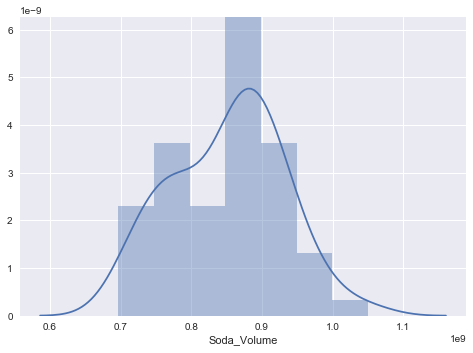

In [13]:
sns.distplot(soda['Soda_Volume'])

In [14]:
def convert_date (x):
    x = str(x)
    y = x[:4]
    m = x[4:]
    d = datetime.strptime("{0} {1} {2}".format(y,m,'01'), "%Y %m %d")
    return d

hist_vol['YearMonth'] = hist_vol['YearMonth'].apply(convert_date)

In [15]:
# hist_vol['24m-SMA']=hist_vol['Volume'].rolling(window=24).mean()
# hist_vol['36m-SMA']=hist_vol['Volume'].rolling(window=36).mean()
# hist_vol['48m-SMA']=hist_vol['Volume'].rolling(window=48).mean()

In [16]:
hist_vol.index = hist_vol['YearMonth']

# hist_vol['Volume'].plot(color='black', figsize=(12,6),label='Volume')
# hist_vol['24m-SMA'].plot(color='green',label='24m-SMA')
# hist_vol['36m-SMA'].plot(color='cyan',label='36m-SMA')
# hist_vol['48m-SMA'].plot(color='blue',label='48m-SMA')
# plt.legend()

In [60]:
hist_vol['predict'] = np.nan
hist_vol.head()

Agency     SKU  YearMonth    Volume  predict
YearMonth                                                  
2013-01-01  Agency_22  SKU_01 2013-01-01   52.2720      NaN
2013-01-01  Agency_22  SKU_02 2013-01-01  110.7000      NaN
2013-01-01  Agency_58  SKU_23 2013-01-01    0.0000      NaN
2013-01-01  Agency_48  SKU_07 2013-01-01   28.3200      NaN
2013-01-01  Agency_22  SKU_05 2013-01-01  238.5387      NaN

In [65]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    #X = X.astype('float32')
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        
        model = ARIMA(history,order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

def best_model(dataset):
    best_score, best_cfg = float("inf"), None
    for p in [0,1,2,3,4,5]:
        for d in [0,1,2,3]:
            for q in [0,1,2,3]:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [83]:
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

sku_list = ['SKU_01', 'SKU_02', 'SKU_23', 'SKU_07', 'SKU_05', 'SKU_17',
       'SKU_04', 'SKU_03', 'SKU_18', 'SKU_24', 'SKU_08', 'SKU_11',
       'SKU_15', 'SKU_21', 'SKU_14', 'SKU_28', 'SKU_20', 'SKU_32',
       'SKU_06', 'SKU_22', 'SKU_12', 'SKU_27', 'SKU_31', 'SKU_34', 'SKU_26']

agency_list = ['Agency_22', 'Agency_58', 'Agency_48', 'Agency_31', 'Agency_40',
       'Agency_53', 'Agency_20', 'Agency_49', 'Agency_41', 'Agency_13',
       'Agency_38', 'Agency_01', 'Agency_51', 'Agency_17', 'Agency_45',
       'Agency_55', 'Agency_50', 'Agency_07', 'Agency_33', 'Agency_10',
       'Agency_08', 'Agency_42', 'Agency_39', 'Agency_23', 'Agency_47',
       'Agency_11', 'Agency_46', 'Agency_30', 'Agency_54', 'Agency_32',
       'Agency_18', 'Agency_57', 'Agency_12', 'Agency_34', 'Agency_59',
       'Agency_19', 'Agency_09', 'Agency_02', 'Agency_44', 'Agency_24',
       'Agency_56', 'Agency_28', 'Agency_16', 'Agency_05', 'Agency_52',
       'Agency_37', 'Agency_35', 'Agency_43', 'Agency_15', 'Agency_36',
       'Agency_25', 'Agency_60', 'Agency_29', 'Agency_03', 'Agency_21',
       'Agency_27', 'Agency_26', 'Agency_04']

pred = {}

for i in range(58):
    for j in range(25):
        
        data = hist_vol[(hist_vol['Agency'] == agency_list[i]) & (hist_vol['SKU'] == sku_list[j])].sort_values(by = ['YearMonth'])
        
        if len(data) == 0:
            continue
        
#         autocorrelation_plot(data['Volume'])
#         plt.show()
        
        X = data['Volume'].values
        model = ARIMA(X, order=(5,1,0))
        
        
        model_fit = model.fit(disp=0,trend='nc')
        output = model_fit.forecast()[0]
        pred[agency_list[i] + sku_list[j]] = output

        
#         plt.plot(test)
#         plt.plot(predictions, color='red')
#         plt.show()
        

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1818: RuntimeWarning: invalid value encountered in sqrt
  fcerr = np.sqrt(np.cumsum(cumsum_n(ma_rep, self.k_diff)**2)*sigma2)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [ ]:
# from pandas.tools.plotting import autocorrelation_plot
# from statsmodels.tsa.arima_model import ARIMA
# from sklearn.metrics import mean_squared_error

# sku_list = ['SKU_01', 'SKU_02', 'SKU_23', 'SKU_07', 'SKU_05', 'SKU_17',
#        'SKU_04', 'SKU_03', 'SKU_18', 'SKU_24', 'SKU_08', 'SKU_11',
#        'SKU_15', 'SKU_21', 'SKU_14', 'SKU_28', 'SKU_20', 'SKU_32',
#        'SKU_06', 'SKU_22', 'SKU_12', 'SKU_27', 'SKU_31', 'SKU_34', 'SKU_26']

# agency_list = ['Agency_22', 'Agency_58', 'Agency_48', 'Agency_31', 'Agency_40',
#        'Agency_53', 'Agency_20', 'Agency_49', 'Agency_41', 'Agency_13',
#        'Agency_38', 'Agency_01', 'Agency_51', 'Agency_17', 'Agency_45',
#        'Agency_55', 'Agency_50', 'Agency_07', 'Agency_33', 'Agency_10',
#        'Agency_08', 'Agency_42', 'Agency_39', 'Agency_23', 'Agency_47',
#        'Agency_11', 'Agency_46', 'Agency_30', 'Agency_54', 'Agency_32',
#        'Agency_18', 'Agency_57', 'Agency_12', 'Agency_34', 'Agency_59',
#        'Agency_19', 'Agency_09', 'Agency_02', 'Agency_44', 'Agency_24',
#        'Agency_56', 'Agency_28', 'Agency_16', 'Agency_05', 'Agency_52',
#        'Agency_37', 'Agency_35', 'Agency_43', 'Agency_15', 'Agency_36',
#        'Agency_25', 'Agency_60', 'Agency_29', 'Agency_03', 'Agency_21',
#        'Agency_27', 'Agency_26', 'Agency_04']

# for i in range(58):
#     for j in range(25):
        
#         data = hist_vol[(hist_vol['Agency'] == agency_list[i]) & (hist_vol['SKU'] == sku_list[j])].sort_values(by = ['YearMonth'])
        
#         if len(data) == 0:
#             continue
        
#         autocorrelation_plot(data['Volume'])
#         plt.show()
        
#         X = data['Volume'].values
#         size = int(len(X) * 0.80)
#         train, test = X[0:size], X[size:len(X)]
#         history = [x for x in train]
#         predictions = list()
#         for t in range(len(test)):
#             model = ARIMA(history, order=(1,1,0))
            
#             try:
                
#                 model_fit = model.fit(disp=0,trend='nc')
#             except:
#                 print (data)
            
#             output = model_fit.forecast()
#             yhat = output[0]
#             predictions.append(yhat)
#             obs = test[t]
#             history.append(obs)
#             #print('predicted=%f, expected=%f' % (yhat, obs))
#         error = mean_squared_error(test, predictions)
#         print('Test MSE: %.3f' % error)
#         # plot
#         plt.plot(test)
#         plt.plot(predictions, color='red')
#         plt.show()
        

In [88]:
for i in range(len(vol_forecast)):
    if not vol_forecast['Agency'][i] + vol_forecast['SKU'][i] in pred:
        vol_forecast['Volume'][i] = 0
    else:
        vol_forecast['Volume'][i] = pred[vol_forecast['Agency'][i] + vol_forecast['SKU'][i]][0]
        
    if vol_forecast['Volume'][i] < 0:
        vol_forecast['Volume'][i] = 0
    
vol_forecast.head()

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Agency     SKU      Volume
0  Agency_23  SKU_06    0.000000
1  Agency_34  SKU_20    0.000000
2  Agency_24  SKU_02  102.865974
3  Agency_40  SKU_06    0.000000
4  Agency_42  SKU_32    0.000000

In [89]:
vol_forecast.to_csv("volume_forecast.csv", index=False)

In [90]:
vol_forecast[vol_forecast['Volume'] <0]

Empty DataFrame
Columns: [Agency, SKU, Volume]
Index: []

In [91]:
for i,j in pred.items() :
    if j < 0:
        print (i)

Agency_58SKU_23
Agency_53SKU_24
Agency_20SKU_23
Agency_38SKU_21
Agency_38SKU_14
Agency_10SKU_23
Agency_54SKU_15
Agency_54SKU_14
Agency_05SKU_14


In [92]:
pred

{'Agency_01SKU_01': array([ 49.19817132]),
 'Agency_01SKU_02': array([ 14.88457408]),
 'Agency_01SKU_03': array([ 12.36040584]),
 'Agency_01SKU_04': array([ 70.61528093]),
 'Agency_01SKU_05': array([ 17.15776588]),
 'Agency_01SKU_11': array([ 23.02316248]),
 'Agency_02SKU_01': array([ 4314.36188212]),
 'Agency_02SKU_02': array([ 5132.52487103]),
 'Agency_02SKU_03': array([ 18537.10720927]),
 'Agency_02SKU_04': array([ 3443.80193072]),
 'Agency_02SKU_05': array([ 1510.37120972]),
 'Agency_02SKU_11': array([ 1.63414382]),
 'Agency_02SKU_12': array([ 16.88689073]),
 'Agency_02SKU_31': array([ 50.69864226]),
 'Agency_02SKU_34': array([ 124.42861983]),
 'Agency_03SKU_01': array([ 606.44892004]),
 'Agency_03SKU_02': array([ 327.13136037]),
 'Agency_03SKU_03': array([ 9985.37111313]),
 'Agency_03SKU_04': array([ 987.43021084]),
 'Agency_03SKU_05': array([ 705.74735439]),
 'Agency_03SKU_32': array([ 0.22150395]),
 'Agency_04SKU_01': array([ 11.44200197]),
 'Agency_04SKU_02': array([ 3.75808689